In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("s8a-analitica-ventas").getOrCreate()

In [10]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
esquema = StructType([
    StructField("Order ID", IntegerType(), False),
    StructField("Product", StringType(), False),
    StructField("Quantity Ordered", IntegerType(), True),
    StructField("Price Each", DoubleType(), False),
    StructField("Order Date", StringType(), False),
    StructField("Purchase Address", StringType(), False)
])

In [11]:
# Mucho más rapido leerlo con el esquema
df = spark.read.option("sep",",").option("header", "true").schema(esquema).csv("salesdata/*.csv")
    
df.printSchema()

root
 |-- Order ID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Price Each: double (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Purchase Address: string (nullable = true)



In [12]:
df.count()

186850

In [13]:
# Mucho más rapido leerlo con el esquema
df = spark.read.option("sep",",").option("header", "true").schema(esquema).csv("../salesdata.zip")
    
df.printSchema()

root
 |-- Order ID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Price Each: double (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Purchase Address: string (nullable = true)



In [14]:
df.count()

19229

In [15]:
df.describe().show()

22/04/20 13:23:49 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 1, schema size: 6
CSV file: file:///Users/aitormedrano/OneDrive%20-%20Conselleria%20d'Educació/2122/bigdata/bigdata2122/docs/recursos/spark/salesdata.zip


+-------+-----------------+--------------------+----------------+----------+--------------------+--------------------+
|summary|         Order ID|             Product|Quantity Ordered|Price Each|          Order Date|    Purchase Address|
+-------+-----------------+--------------------+----------------+----------+--------------------+--------------------+
|  count|               11|                6209|               1|         0|                 217|                  64|
|   mean|              9.0|   4.333333333333333|             3.0|      null|                null|                null|
| stddev|11.16243700990066|  2.0816659994661326|            null|      null|                null|                null|
|    min|                0|                    |               3|      null|               $:��C|5��i`؅'|\�V=�7�...|
|    max|               34|�󪨈L���I�������...|               3|      null|������D��y��n��.�...|������}&����J(�...|
+-------+-----------------+--------------------+-

In [53]:
# Limpieza de datos


# Quitar nulos

# Quitar encabezados

In [54]:
#Renombrar campos
ventas = df.withColumnRenamed("Order ID", "OrderID").withColumnRenamed("Quantity Ordered", "Quantity").withColumnRenamed("Price Each", "Price")
ventas = ventas.withColumnRenamed("Order Date", "OrderDate").withColumnRenamed("Purchase Address", "OrderAddress")

In [55]:
# Comprobamos si tenemos campos nulos
from pyspark.sql.functions import col
ventas.filter(col("OrderID").isNull()).show()

+-------+-------+--------+-----+----------+----------------+
|OrderID|Product|Quantity|Price| OrderDate|    OrderAddress|
+-------+-------+--------+-----+----------+----------------+
|   null|Product|    null| null|Order Date|Purchase Address|
|   null|   null|    null| null|      null|            null|
|   null|   null|    null| null|      null|            null|
|   null|   null|    null| null|      null|            null|
|   null|Product|    null| null|Order Date|Purchase Address|
|   null|Product|    null| null|Order Date|Purchase Address|
|   null|   null|    null| null|      null|            null|
|   null|   null|    null| null|      null|            null|
|   null|   null|    null| null|      null|            null|
|   null|   null|    null| null|      null|            null|
|   null|Product|    null| null|Order Date|Purchase Address|
|   null|   null|    null| null|      null|            null|
|   null|   null|    null| null|      null|            null|
|   null|   null|    nul

In [56]:
# Quitar nulos
ventasSinNulos = ventas.na.drop("any")
# Comprobamos
ventasSinNulos.filter(col("OrderID").isNull()).show()

+-------+-------+--------+-----+---------+------------+
|OrderID|Product|Quantity|Price|OrderDate|OrderAddress|
+-------+-------+--------+-----+---------+------------+
+-------+-------+--------+-----+---------+------------+



In [57]:
# Comprobamos las cabeceras
encabezados = ventasSinNulos.filter((col("OrderID") == "Order ID") | (col("Product") == "Product"))
encabezados.show()

+-------+-------+--------+-----+---------+------------+
|OrderID|Product|Quantity|Price|OrderDate|OrderAddress|
+-------+-------+--------+-----+---------+------------+
+-------+-------+--------+-----+---------+------------+



In [58]:
# Obtener la ciudad y el estado
ventasSinNulos.select("OrderAddress").show(10,False)

+-----------------------------------------+
|OrderAddress                             |
+-----------------------------------------+
|136 Church St, New York City, NY 10001   |
|562 2nd St, New York City, NY 10001      |
|277 Main St, New York City, NY 10001     |
|410 6th St, San Francisco, CA 94016      |
|43 Hill St, Atlanta, GA 30301            |
|200 Jefferson St, New York City, NY 10001|
|928 12th St, Portland, OR 97035          |
|813 Hickory St, Dallas, TX 75001         |
|718 Wilson St, Dallas, TX 75001          |
|77 7th St, Dallas, TX 75001              |
+-----------------------------------------+
only showing top 10 rows



In [59]:
# Si separamos por comas, la ciudad es la de en medio, y el estado las dos letras mayúculas de la tercera
from pyspark.sql.functions import split, trim
ventasCiudad = ventasSinNulos.withColumn("City", trim(split(col("OrderAddress"), ",")[1]))
ventasEstado = ventasCiudad.withColumn("State", trim(split(split(col("OrderAddress"), ",")[2], " ")[1]))
ventasEstado.show()

+-------+--------------------+--------+------+--------------+--------------------+-------------+-----+
|OrderID|             Product|Quantity| Price|     OrderDate|        OrderAddress|         City|State|
+-------+--------------------+--------+------+--------------+--------------------+-------------+-----+
| 295665|  Macbook Pro Laptop|       1|1700.0|12/30/19 00:01|136 Church St, Ne...|New York City|   NY|
| 295666|  LG Washing Machine|       1| 600.0|12/29/19 07:03|562 2nd St, New Y...|New York City|   NY|
| 295667|USB-C Charging Cable|       1| 11.95|12/12/19 18:21|277 Main St, New ...|New York City|   NY|
| 295668|    27in FHD Monitor|       1|149.99|12/22/19 15:13|410 6th St, San F...|San Francisco|   CA|
| 295669|USB-C Charging Cable|       1| 11.95|12/18/19 12:38|43 Hill St, Atlan...|      Atlanta|   GA|
| 295670|AA Batteries (4-p...|       1|  3.84|12/31/19 22:58|200 Jefferson St,...|New York City|   NY|
| 295671|USB-C Charging Cable|       1| 11.95|12/16/19 15:10|928 12th St,

In [61]:
# Cambiamos el campo fecha
from pyspark.sql.functions import to_timestamp
ventas = ventasEstado.withColumn("OrderDate", to_timestamp(ventasEstado.OrderDate, "MM/dd/yy HH:mm"))
ventas.show()

+-------+--------------------+--------+------+-------------------+--------------------+-------------+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        OrderAddress|         City|State|
+-------+--------------------+--------+------+-------------------+--------------------+-------------+-----+
| 295665|  Macbook Pro Laptop|       1|1700.0|2019-12-30 00:01:00|136 Church St, Ne...|New York City|   NY|
| 295666|  LG Washing Machine|       1| 600.0|2019-12-29 07:03:00|562 2nd St, New Y...|New York City|   NY|
| 295667|USB-C Charging Cable|       1| 11.95|2019-12-12 18:21:00|277 Main St, New ...|New York City|   NY|
| 295668|    27in FHD Monitor|       1|149.99|2019-12-22 15:13:00|410 6th St, San F...|San Francisco|   CA|
| 295669|USB-C Charging Cable|       1| 11.95|2019-12-18 12:38:00|43 Hill St, Atlan...|      Atlanta|   GA|
| 295670|AA Batteries (4-p...|       1|  3.84|2019-12-31 22:58:00|200 Jefferson St,...|New York City|   NY|
| 295671|USB-C Charging Cabl

In [63]:
# Añadimos columnas Year y Month
from pyspark.sql.functions import year, month
ventas = ventas.withColumn("Year", year("OrderDate")).withColumn("Month", month("OrderDate"))
ventas.show()

+-------+--------------------+--------+------+-------------------+--------------------+-------------+-----+----+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        OrderAddress|         City|State|Year|Month|
+-------+--------------------+--------+------+-------------------+--------------------+-------------+-----+----+-----+
| 295665|  Macbook Pro Laptop|       1|1700.0|2019-12-30 00:01:00|136 Church St, Ne...|New York City|   NY|2019|   12|
| 295666|  LG Washing Machine|       1| 600.0|2019-12-29 07:03:00|562 2nd St, New Y...|New York City|   NY|2019|   12|
| 295667|USB-C Charging Cable|       1| 11.95|2019-12-12 18:21:00|277 Main St, New ...|New York City|   NY|2019|   12|
| 295668|    27in FHD Monitor|       1|149.99|2019-12-22 15:13:00|410 6th St, San F...|San Francisco|   CA|2019|   12|
| 295669|USB-C Charging Cable|       1| 11.95|2019-12-18 12:38:00|43 Hill St, Atlan...|      Atlanta|   GA|2019|   12|
| 295670|AA Batteries (4-p...|       1|  3.84|20

In [64]:
# Escribir en parquet con los datos particionados
ventas.write.mode("overwrite").partitionBy("Year", "Month").parquet("./salesdataoutput/")

In [3]:
# Leemos solo los datos de 2019. Notad que no ha leído el campo Year
ventas2019 = spark.read.parquet("./salesdataoutput/Year=2019")
ventas2019.printSchema()

root
 |-- OrderID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price: double (nullable = true)
 |-- OrderDate: timestamp (nullable = true)
 |-- OrderAddress: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Month: integer (nullable = true)



### Mejor mes en ventas

In [6]:
from pyspark.sql.functions import round, sum, expr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
ventas2019df = ventas2019.select("OrderID", "Month", "Price", "Quantity", expr("Price * Quantity").alias("Ventas"))
ventas2019df.show(10)

+-------+-----+------+--------+------+
|OrderID|Month| Price|Quantity|Ventas|
+-------+-----+------+--------+------+
| 295665|   12|1700.0|       1|1700.0|
| 295666|   12| 600.0|       1| 600.0|
| 295667|   12| 11.95|       1| 11.95|
| 295668|   12|149.99|       1|149.99|
| 295669|   12| 11.95|       1| 11.95|
| 295670|   12|  3.84|       1|  3.84|
| 295671|   12| 11.95|       1| 11.95|
| 295672|   12| 11.95|       2|  23.9|
| 295673|   12| 99.99|       1| 99.99|
| 295674|   12|  2.99|       4| 11.96|
+-------+-----+------+--------+------+
only showing top 10 rows



In [13]:
ventasMes = ventas2019df.groupBy("Month").agg(round(sum("Ventas"), 2).alias("TotalVentas")).orderBy("TotalVentas", ascending=False)
ventasMes.show()

+-----+-----------+
|Month|TotalVentas|
+-----+-----------+
|   12| 4613443.34|
|   10| 3736726.88|
|    4| 3390670.24|
|   11|  3199603.2|
|    5| 3152606.75|
|    3| 2807100.38|
|    7| 2647775.76|
|    6| 2577802.26|
|    8| 2244467.88|
|    2| 2202022.42|
|    9| 2097560.13|
|    1| 1813586.44|
+-----+-----------+



In [14]:
ventasMes_pd = ventasMes.orderBy("Month").toPandas()
ventasMes_pd

,Month,TotalVentas
0,1,1813586.44
1,2,2202022.42
2,3,2807100.38
3,4,3390670.24
4,5,3152606.75
5,6,2577802.26
6,7,2647775.76
7,8,2244467.88
8,9,2097560.13
9,10,3736726.88


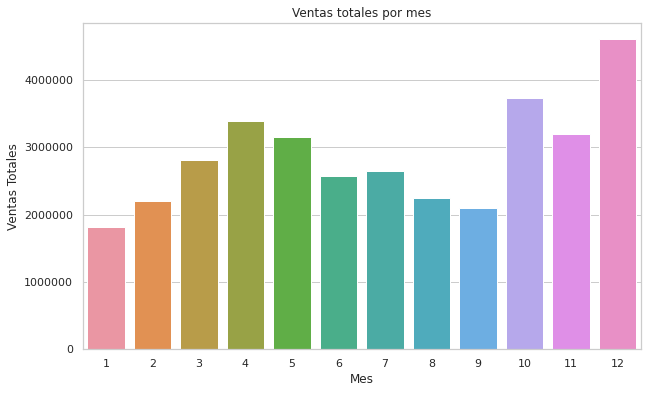

In [18]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="whitegrid")
sns.barplot(x="Month", y="TotalVentas", data=ventasMes_pd).set_title("Ventas totales por mes")
plt.xlabel("Mes")
plt.ylabel("Ventas Totales")
plt.show()

### Ciudad que vendió más productos

In [22]:
ventas19c = ventas2019.select("City", "OrderID", "Quantity")
ventas19c.show()

+-------------+-------+--------+
|         City|OrderID|Quantity|
+-------------+-------+--------+
|New York City| 295665|       1|
|New York City| 295666|       1|
|New York City| 295667|       1|
|San Francisco| 295668|       1|
|      Atlanta| 295669|       1|
|New York City| 295670|       1|
|     Portland| 295671|       1|
|       Dallas| 295672|       2|
|       Dallas| 295673|       1|
|       Dallas| 295674|       4|
|San Francisco| 295675|       2|
|  Los Angeles| 295676|       1|
|       Boston| 295677|       2|
|       Dallas| 295678|       2|
|       Dallas| 295679|       1|
|       Austin| 295680|       1|
|       Boston| 295681|       1|
|       Boston| 295681|       1|
|       Boston| 295681|       1|
|       Boston| 295681|       1|
+-------------+-------+--------+
only showing top 20 rows



In [27]:
ventas19ciudad = ventas19c.groupBy("City").agg(sum("Quantity").alias("Total")).orderBy("Total", ascending=False)
ventas19ciudad.show()

+-------------+-----+
|         City|Total|
+-------------+-----+
|San Francisco|50226|
|  Los Angeles|33288|
|New York City|27916|
|       Boston|22524|
|       Dallas|16728|
|      Atlanta|16602|
|      Seattle|16552|
|     Portland|14051|
|       Austin|11151|
+-------------+-----+



In [29]:
ventasCiudad_pd = ventas19ciudad.toPandas()
ventasCiudad_pd

,City,Total
0,San Francisco,50226
1,Los Angeles,33288
2,New York City,27916
3,Boston,22524
4,Dallas,16728
5,Atlanta,16602
6,Seattle,16552
7,Portland,14051
8,Austin,11151


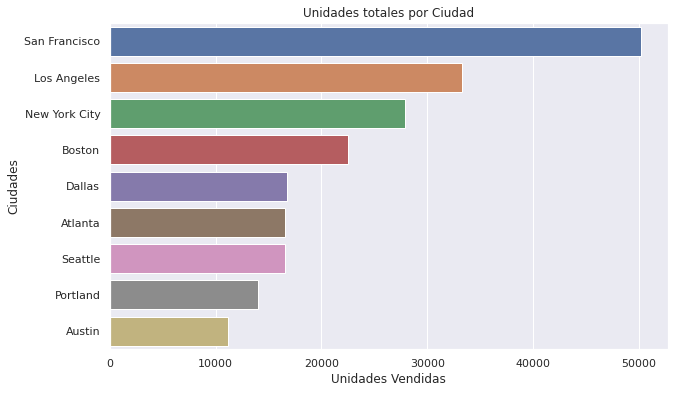

In [32]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="darkgrid")
sns.barplot(x="Total", y="City", data=ventasCiudad_pd).set_title("Unidades totales por Ciudad")
plt.xlabel("Unidades Vendidas")
plt.ylabel("Ciudades")
plt.show()

### Pedidos que han comprado más de un producto

In [35]:
# miramos si los pedido se pueden realizar sobre más de un producto
from pyspark.sql.functions import col
ventas2019.groupBy("OrderID", "OrderDate").count().where(col("count") > 1).show()

+-------+-------------------+-----+
|OrderID|          OrderDate|count|
+-------+-------------------+-----+
| 298744|2019-12-26 12:42:00|    2|
| 314361|2019-12-11 23:16:00|    2|
| 319032|2019-12-05 17:19:00|    2|
| 260300|2019-10-28 10:33:00|    2|
| 263719|2019-10-28 10:44:00|    3|
| 272154|2019-10-01 08:01:00|    2|
| 277689|2019-10-29 11:50:00|    3|
| 178221|2019-04-21 09:21:00|    2|
| 184712|2019-04-20 18:35:00|    2|
| 187955|2019-04-03 12:51:00|    2|
| 260763|2019-10-01 09:59:00|    2|
| 186331|2019-04-09 09:35:00|    2|
| 281110|2019-11-29 19:58:00|    2|
| 291509|2019-11-09 14:40:00|    2|
| 198016|2019-05-13 15:41:00|    2|
| 202521|2019-05-03 09:15:00|    2|
| 203384|2019-05-24 08:45:00|    2|
| 204914|2019-05-25 18:49:00|    2|
| 303051|2019-12-25 19:15:00|    2|
| 309690|2019-12-17 22:05:00|    2|
+-------+-------------------+-----+
only showing top 20 rows



### Hora en la que se ha comprado más de un producto

In [45]:
from pyspark.sql.functions import date_format, count
ventas2019horas = ventas2019.select("OrderID", date_format("OrderDate", "HH").cast("int").alias("Hora")).distinct().groupBy("Hora").agg(count("Hora").alias("TotalPedidos")).orderBy("TotalPedidos", ascending=False)
ventas2019horas.show()

+----+------------+
|Hora|TotalPedidos|
+----+------------+
|  17|       12149|
|  18|       12076|
|  10|       12018|
|  11|       11776|
|   9|       11274|
|  12|       11155|
|  16|       11064|
|  19|       11043|
|  15|       10317|
|  13|       10019|
|  14|        9875|
|   8|        9520|
|  20|        9379|
|   7|        7302|
|  21|        6998|
|   6|        5154|
|  22|        4847|
|   5|        3208|
|  23|        2864|
|   4|        1865|
+----+------------+
only showing top 20 rows



In [47]:
ventasHoras_pd = ventas2019horas.orderBy("Hora").toPandas()
ventasHoras_pd

,Hora,TotalPedidos
0,0,1652
1,1,980
2,2,807
3,3,1064
4,4,1865
5,5,3208
6,6,5154
7,7,7302
8,8,9520
9,9,11274


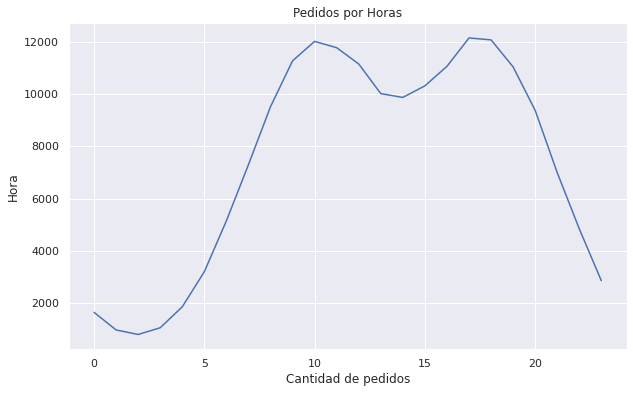

In [50]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="darkgrid")
sns.lineplot(x="Hora", y="TotalPedidos", data=ventasHoras_pd).set_title("Pedidos por Horas")
plt.xlabel("Cantidad de pedidos")
plt.ylabel("Hora")
plt.show()

### Productos comprados a la vez en el estado de NY


In [69]:
from pyspark.sql.functions import collect_list
productos_ny = ventas2019.where("State = 'NY'").groupBy("OrderID").agg(collect_list("Product").alias("Productos"), count("Product").alias("CantidadProductos"))
productos_ny.show(truncate=False)

+-------+-----------------------------------+-----------------+
|OrderID|Productos                          |CantidadProductos|
+-------+-----------------------------------+-----------------+
|141264 |[Apple Airpods Headphones]         |1                |
|141268 |[AA Batteries (4-pack)]            |1                |
|141272 |[AAA Batteries (4-pack)]           |1                |
|141278 |[Lightning Charging Cable]         |1                |
|141282 |[Vareebadd Phone]                  |1                |
|141301 |[Apple Airpods Headphones]         |1                |
|141314 |[Macbook Pro Laptop]               |1                |
|141317 |[27in FHD Monitor]                 |1                |
|141323 |[USB-C Charging Cable]             |1                |
|141343 |[Bose SoundSport Headphones]       |1                |
|141349 |[Lightning Charging Cable]         |1                |
|141353 |[USB-C Charging Cable]             |1                |
|141365 |[Vareebadd Phone, Wired Headpho

In [71]:
# Nos quedamos con los pedidos que tienen dos o más productos
productos2 = productos_ny.filter("CantidadProductos > 1")
productos2.show(truncate=False)

+-------+--------------------------------------------------+-----------------+
|OrderID|Productos                                         |CantidadProductos|
+-------+--------------------------------------------------+-----------------+
|141365 |[Vareebadd Phone, Wired Headphones]               |2                |
|141645 |[Lightning Charging Cable, Wired Headphones]      |2                |
|141910 |[Vareebadd Phone, Wired Headphones]               |2                |
|142039 |[Google Phone, USB-C Charging Cable]              |2                |
|142144 |[Vareebadd Phone, USB-C Charging Cable]           |2                |
|142320 |[iPhone, Google Phone]                            |2                |
|142389 |[iPhone, Lightning Charging Cable]                |2                |
|142419 |[Google Phone, Wired Headphones]                  |2                |
|142651 |[USB-C Charging Cable, AA Batteries (4-pack)]     |2                |
|142730 |[Google Phone, USB-C Charging Cable]       

In [76]:
# Contamos los productos
productos2.groupBy("Productos").count().orderBy("count", ascending=False).show(truncate = False)

+------------------------------------------------------------+-----+
|Productos                                                   |count|
+------------------------------------------------------------+-----+
|[iPhone, Lightning Charging Cable]                          |126  |
|[Google Phone, USB-C Charging Cable]                        |124  |
|[Google Phone, Wired Headphones]                            |52   |
|[Vareebadd Phone, USB-C Charging Cable]                     |49   |
|[iPhone, Wired Headphones]                                  |46   |
|[iPhone, Apple Airpods Headphones]                          |43   |
|[Google Phone, Bose SoundSport Headphones]                  |23   |
|[Vareebadd Phone, Wired Headphones]                         |17   |
|[Apple Airpods Headphones, Wired Headphones]                |12   |
|[Google Phone, USB-C Charging Cable, Wired Headphones]      |11   |
|[AA Batteries (4-pack), Apple Airpods Headphones]           |10   |
|[Lightning Charging Cable, AAA Ba